In [3]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier, BaggingClassifier

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
# считываем csv
df = pd.read_csv("df_after_eda.csv")
df = df.drop(["Unnamed: 0"], axis=1)
df.head()

,inn,n_requests,documents_len,result_type_proigrano,result_type_viygrano,result_type_ne_udalos_opredelit,num_of_active_cases,case_side_type_0,case_side_type_1,case_side_type_2,proigrano_sum,viygrano_sum,cases_len,is_bankrupt,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year
0,7736609147,1,253,23,6,23,1,2,57,0,51153662.45,10395854.55,59,1,2012.0,0.0,75255.0,85541.0
1,5028024427,1,99,1,0,1,1,1,1,0,4269304.88,0.00,4,1,2013.0,0.0,59825.0,48360.0
2,7622005092,1,0,0,0,0,0,0,0,0,0.00,0.00,0,0,NaN,NaN,NaN,NaN
3,7455005950,1,76,1,2,2,1,1,5,0,7779.05,808000.00,6,1,2013.0,38411.0,4198.0,45890.0
4,2111000271,1,150,1,2,9,0,3,10,0,2439854.48,2439854.48,13,1,2012.0,0.0,0.0,6122.0


In [8]:
# делим выборки
x_df = df.drop(["is_bankrupt"], axis=1)
y_df = df["is_bankrupt"]

In [23]:
df["is_bankrupt"].value_counts()

1    106
0     87
Name: is_bankrupt, dtype: int64

In [208]:
# поскольку данные табличные, то здесь лучше всего подойет ансамбль уточняющих друг друга деревьев -- градиентный бустинг,
# тем более что это многократный победитель соревнований kaggle на табличных данных.

# Поскольку один класс ненамного превосходит другой (106 против 87), то целевая метрика для этой задачи -- accuracy,
# в противном случае, это была ба F1. Но для наглядности ниже приводятся графики и для precision/recall для каждого из классов.

# Ниже обучаются модели XGboost и Catboost (без поиска гиперпараметров). А так как эти две реализации град. бустинга умеют работать с NaN, то 
# отсутствующие значения никак не предобрабатываются.

## XGBoost

In [9]:
N_FOLDS = 20

accuracy_list_xgb = []
precision_class_0_list = []
recall_class_0_list = []
precision_class_1_list = []
recall_class_1_list = []

# так как данных очень мало, то "стандартная" кросс-валидация может не показать актуальные метрики
# (потому что, например, при пяти фолдах для валидации останется меньше 40 образцов, что нехорошо, однако для сравнения 
# я все равно провожу такую кросс валидацию ниже),
# поэтому мной была выбрана кросс-валидация через бутстрэпинг, то есть N_FOLDS раз перемешивается
# выборка и достаются тренировочные и тестовые данные

for fold in range(N_FOLDS):
    # иниц модель внутри for, а не снаружи, чтобы не возникало оверфиттинга
    xgb_model = XGBClassifier()
    x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, shuffle=True)
    xgb_model.fit(x_train, y_train)
    predicted_arr = xgb_model.predict(x_test)
    acc = accuracy_score(y_pred=predicted_arr, y_true=y_test)
    # собираем accuracy
    accuracy_list_xgb.append(acc)
    report_dict = classification_report(y_pred=predicted_arr, y_true=y_test, output_dict=True)
    
    precision_class_0_list.append(report_dict['0']['precision'])
    recall_class_0_list.append(report_dict['0']['recall'])
    precision_class_1_list.append(report_dict['1']['precision'])
    recall_class_1_list.append(report_dict['1']['recall'])


In [11]:
accuracy_list_xgb

[0.8205128205128205,
 0.7692307692307693,
 0.8205128205128205,
 0.7692307692307693,
 0.8974358974358975,
 0.8717948717948718,
 0.8717948717948718,
 0.8205128205128205,
 0.8717948717948718,
 0.8461538461538461,
 0.9230769230769231,
 0.7435897435897436,
 0.8717948717948718,
 0.8461538461538461,
 0.8205128205128205,
 0.8717948717948718,
 0.8974358974358975,
 0.8717948717948718,
 0.8717948717948718,
 0.8205128205128205]

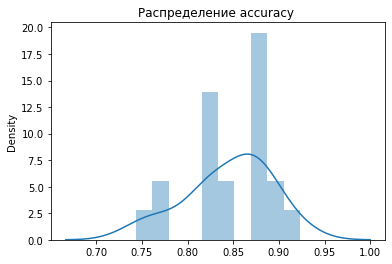

In [13]:
sns.distplot(accuracy_list_xgb, bins=10)
plt.title("Распределение accuracy ")
plt.show()

In [14]:
print(f"Медиана acc.: {np.median(accuracy_list_xgb)}")
print(f"Среднее acc.: {np.mean(accuracy_list_xgb)}")

Медиана acc.: 0.858974358974359
Среднее acc.: 0.8448717948717949


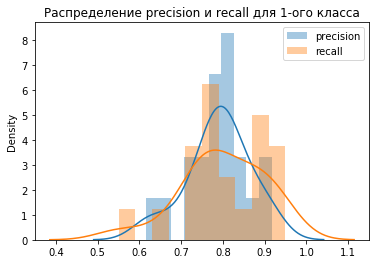

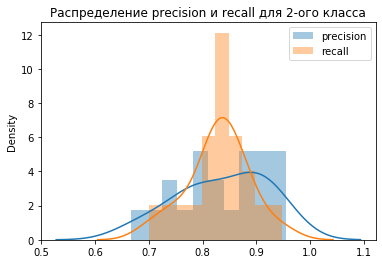

In [202]:

sns.distplot(precision_class_0_list, bins=10, label="precision")
sns.distplot(recall_class_0_list, bins=10, label="recall")
plt.title("Распределение precision и recall для 1-ого класса")
plt.legend()
plt.show()


sns.distplot(precision_class_1_list, bins=10, label="precision")
sns.distplot(recall_class_1_list, bins=10, label="recall")
plt.title("Распределение precision и recall для 2-ого класса")
plt.legend()
plt.show()


#### Обычная кросс-валидация

In [25]:
model = XGBClassifier()
val_scores_xgboost = cross_val_score(model, x_df, y_df, cv=5, scoring='accuracy')

In [26]:
val_scores_xgboost

array([0.79487179, 0.82051282, 0.84615385, 0.86842105, 0.84210526])

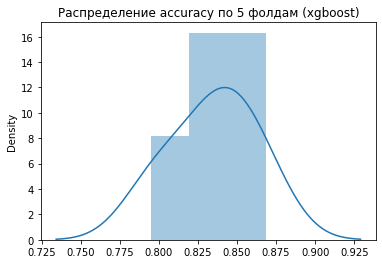

In [27]:
sns.distplot(val_scores_xgboost)
plt.title("Распределение accuracy по 5 фолдам (xgboost)")
plt.show()

In [28]:
print(f"Медиана acc. при 5 фолдах: {np.median(val_scores_xgboost)}")
print(f"Среднее acc. при 5 фолдах: {np.mean(val_scores_xgboost)}")

Медиана acc. при 5 фолдах: 0.8421052631578947
Среднее acc. при 5 фолдах: 0.834412955465587


## CatBoost

In [15]:
N_FOLDS = 20

accuracy_list_catboost = []
precision_class_0_list = []
recall_class_0_list = []
precision_class_1_list = []
recall_class_1_list = []

# так как данных мало, то "стандартная" кросс-валидация может не показать актуальные метрики 
# (потому что, например, при пяти фолдах для валидации останется меньше 40 образцов, однако для сравнения 
# я все равно провожу такую кросс валидацию ниже),
# поэтому тут я валидирую через бутстрэпинг, то есть N_FOLDS раз перемешивается
# выборка и достаются оттуда тренировочные и тестовые данные

for fold in range(N_FOLDS):
    # иниц модель внутри for, а не снаружи, чтобы не возникало оверфиттинга
    cb_model = CatBoostClassifier(logging_level='Silent')
    x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, shuffle=True)
    cb_model.fit(x_train, y_train)
    predicted_arr = cb_model.predict(x_test)
    acc = accuracy_score(y_pred=predicted_arr, y_true=y_test)
    # собираем accuracy
    accuracy_list_catboost.append(acc)
    
    report_dict = classification_report(y_pred=predicted_arr, y_true=y_test, output_dict=True)
    
    precision_class_0_list.append(report_dict['0']['precision'])
    recall_class_0_list.append(report_dict['0']['recall'])
    precision_class_1_list.append(report_dict['1']['precision'])
    recall_class_1_list.append(report_dict['1']['recall'])



In [16]:
accuracy_list_catboost

[0.8205128205128205,
 0.8717948717948718,
 0.7948717948717948,
 0.8205128205128205,
 0.8461538461538461,
 0.8717948717948718,
 0.7948717948717948,
 0.8717948717948718,
 0.9743589743589743,
 0.8461538461538461,
 0.7692307692307693,
 0.8717948717948718,
 0.8717948717948718,
 0.9230769230769231,
 0.8461538461538461,
 0.8974358974358975,
 0.7692307692307693,
 0.8717948717948718,
 0.8461538461538461,
 0.8717948717948718]

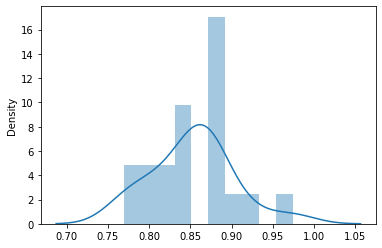

In [17]:
sns.distplot(accuracy_list_catboost, bins=10)
plt.show()

In [18]:
print(f"Медиана acc.: {np.median(accuracy_list_catboost)}")
print(f"Среднее acc.: {np.mean(accuracy_list_catboost)}")

Медиана acc.: 0.858974358974359
Среднее acc.: 0.8525641025641028


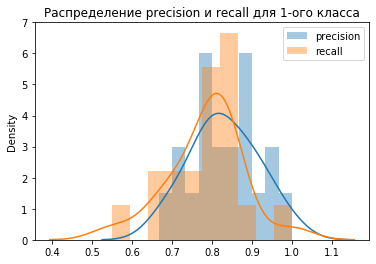

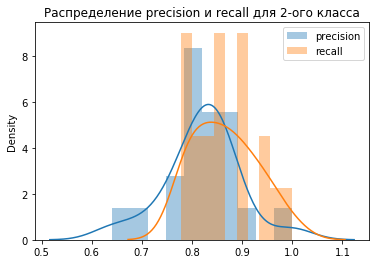

In [196]:
sns.distplot(precision_class_0_list, bins=10, label="precision")
sns.distplot(recall_class_0_list, bins=10, label="recall")
plt.title("Распределение precision и recall для 1-ого класса")
plt.legend()
plt.show()


sns.distplot(precision_class_1_list, bins=10, label="precision")
sns.distplot(recall_class_1_list, bins=10, label="recall")
plt.title("Распределение precision и recall для 2-ого класса")
plt.legend()
plt.show()

#### Обычная кросс-валидация

In [21]:
model = CatBoostClassifier(logging_level="Silent")
val_scores_catboost = cross_val_score(model, x_df, y_df, cv=5, scoring='accuracy')

In [22]:
val_scores_catboost

array([0.84615385, 0.84615385, 0.84615385, 0.81578947, 0.81578947])

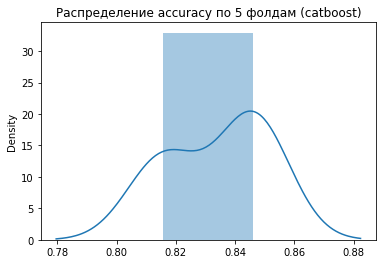

In [23]:
sns.distplot(val_scores_catboost)
plt.title("Распределение accuracy по 5 фолдам (catboost)")
plt.show()

In [24]:
print(f"Медиана acc. по 5 фолдам: {np.median(val_scores_catboost)}")
print(f"Среднее acc. по 5 фолдам: {np.mean(val_scores_catboost)}")

Медиана acc. по 5 фолдам: 0.8461538461538461
Среднее acc. по 5 фолдам: 0.8340080971659919


## Сравнительный стат. анализ между XGBoost и CatBoost: что лучше (для этих данных)?

In [19]:
from scipy import stats

In [20]:
stats.ttest_ind(accuracy_list_xgb, accuracy_list_catboost)

Ttest_indResult(statistic=-0.5038824764876938, pvalue=0.6172529341151755)

In [29]:
stats.ttest_ind(val_scores_catboost, val_scores_xgboost)

Ttest_indResult(statistic=-0.02788255815369995, pvalue=0.978438827034565)

In [ ]:
# p-value для выборок и при 20 "нестандартных" фолдах, и при 5 "стандартных" фолдах намного больше порога 0.05
# значит, гипотеза о равенстве средних принимается -> значит, нет разницы между xgboost и catboost для этих данных

## Ансамбль

In [ ]:
# построим простенький ансамбль с soft-голосованием из xgboost и catboost

In [30]:
N_FOLDS = 20

accuracy_list_ensemble = []

# так как данных мало, то "стандартная" кросс-валидация может не показать актуальные метрики,
# поэтому мной была выбрана кросс-валидация через бутстрэпинг, то есть N_FOLDS раз перемешивается
# выборка и достаются тренировочные и тестовые данные

for fold in range(N_FOLDS):
    # иниц модель внутри for, а не снаружи, чтобы не возникало оверфиттинга
    voting_clf_ensemble = VotingClassifier(voting='soft', estimators = [
        ('catboost', CatBoostClassifier(logging_level="Silent")),
        ('xgboost', XGBClassifier())
    ])
    x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, shuffle=True)
    voting_clf_ensemble.fit(x_train, y_train)
    predicted_arr = voting_clf_ensemble.predict(x_test)
    acc = accuracy_score(y_pred=predicted_arr, y_true=y_test)
    # собираем accuracy
    accuracy_list_ensemble.append(acc)


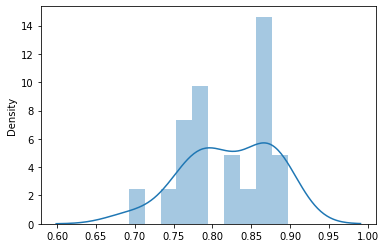

In [31]:
sns.distplot(accuracy_list_ensemble, bins=10)
plt.show()

### Стандратная кросс-валидация (5 фолдов)

In [40]:
model = VotingClassifier(voting='soft', estimators = [
        ('catboost', CatBoostClassifier(logging_level="Silent")),
        ('xgboost', XGBClassifier())
    ])

val_scores_ensemble = cross_val_score(model, x_df, y_df, cv=5, scoring='accuracy')

In [41]:
val_scores_ensemble

array([0.84615385, 0.84615385, 0.84615385, 0.81578947, 0.86842105])

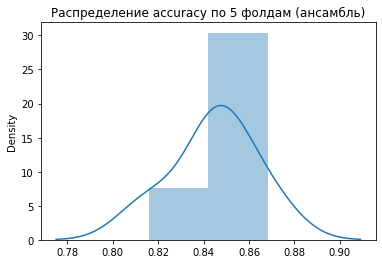

In [42]:
sns.distplot(val_scores_ensemble)
plt.title("Распределение accuracy по 5 фолдам (ансамбль)")
plt.show()

### Стандартная кросс-валидация (3 фолда)

In [37]:
model = VotingClassifier(voting='soft', estimators = [
        ('catboost', CatBoostClassifier(logging_level="Silent")),
        ('xgboost', XGBClassifier())
    ])

val_scores_ensemble = cross_val_score(model, x_df, y_df, cv=3, scoring='accuracy')

In [38]:
val_scores_ensemble

array([0.83076923, 0.828125  , 0.796875  ])

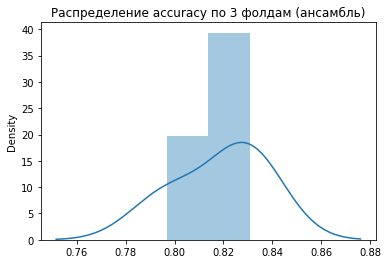

In [39]:
sns.distplot(val_scores_ensemble)
plt.title("Распределение accuracy по 3 фолдам (ансамбль)")
plt.show()

In [43]:
# Вывод: catboost и xgboost одинаково хорошо показали себя на этой задачи, дав результат accuracy примерно 0.84